In [1]:
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
import glob
import numpy as np
import os, glob
import csv
import operator
from matplotlib import rcParams


def buildDataFrame(filePath, colNames, dropCols, numericCols, quant, cut):
    df_temp = pd.read_csv(filePath,names=colNames)
    for colName in dropCols:
        df_temp = df_temp.drop(colName, 1)
    df_temp = df_temp[numericCols].apply(pd.to_numeric,errors='coerce')
    df_temp = df_temp.sort_values(by='start_ts', ascending=[True])
    if quant != 0:
        df_temp = df_temp[df_temp.start_ts > df_temp.start_ts.quantile(quant)]
    if cut != 0:
        df_temp = df_temp[df_temp.latency < cut]
    return df_temp

#['geo','latency','mx','mn','wc','start_ts']
def pruneForDenseWindows(dataframe,percentage):
    pd.to_numeric(dataframe.wc)
    topWindows = dataframe.wc.quantile(percentage)
    #print(topWindows)
    dataframe = dataframe[dataframe.wc > topWindows  ]
    return dataframe


def pandasDraw(listOfFilePaths,_figsize,_range, colNames, dropCols, numericCols, quant, isLatency):
    for fileGroup in listOfFilePaths:
        df_list = []
        for file in fileGroup:
            column_name = file.rsplit('.', 1)[0]
            temp_df = buildDataFrame(file, colNames, dropCols, numericCols, quant)
            if(isLatency):
                temp_df_with_cols = pd.DataFrame({column_name:temp_df.latency},
                    columns=[column_name])
                df_list.append(temp_df_with_cols)
            else:
                temp_df_with_cols = pd.DataFrame({column_name:temp_df.its},
                    columns=[column_name])
                df_list.append(temp_df_with_cols)
        df_final = pd.concat(df_list)
        ax_df_final = df_final.hist(figsize=_figsize,bins=100,range=_range)
    plt.show()
    


def dataGeneratorStats(path,_figsize):
    d = {}
    fileCount = 0
    for filePath in glob.glob(path + '*'):
        fileCount = fileCount + 1
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) , 1
            k = int(k)
            if k in d:
                d[k]  = tuple(map(operator.add, d[k], v))
            else:
                d[k] = v
    finalD = {}
    for k, v in d.items():
        if v[1] == fileCount:
            finalD[k] = v[0]
    df = pd.DataFrame(list(finalD.items()),columns=['ts', 'count'])
    df = df.sort_values(by='ts', ascending=[True])
    df.plot.bar(y='count', x = 'ts',figsize=_figsize,)
    plt.show()

def dataGeneratorStatsSeparate(path,_figsize,_xlabel,_ylabel,_xticks):
    df_list = []
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] , 'count': [int(i[1]) for i in d.items()]},columns=['ts', 'count'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df_list.append(df)
        ax=df.plot(y='count', x = 'ts',figsize=_figsize, xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks) ,marker='x')
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)

    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    plt.show()

def dataGeneratorStatsSeparateOneAxis(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        d = {}
        reader = csv.reader(open(filePath, 'r'))
        for row in reader:
            k , v = row
            v = int(v) 
            k = int(k)
            d[k] = v
        #print( [int(i[1]) for i in d.items()] )
        df = pd.DataFrame({'ts':[int(i[0]) for i in d.items()] },columns=['ts'])
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl
        df['count'] = list(range(1, len(df) + 1))


        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

    
def dataGeneratorStatsSeparateOneAxis2(path,_figsize,_xlabel,_ylabel,_xticks):
    for filePath in glob.glob(path + '*'):
        df = pd.read_csv(filePath,names=['ts','count'])
        df['count'] = df['count']/1000000;
        df = df.sort_values(by='ts', ascending=[True])
        minEl = df.ts.iloc[0]
        df['ts'] = df['ts'] - minEl

        

        ax = df.plot.line( x = 'ts',
                          y='count',
                          figsize=_figsize, 
                          marker='x',
                          xticks = np.arange(df.ts.min(),  df.ts.max(), _xticks))
        ax.set_xlabel(_xlabel)
        ax.set_ylabel(_ylabel)
        
    #df_final = pd.concat(df_list)
    #ax_df_final = df_final.plot.bar(y='count', x = 'ts',figsize=_figsize)
    
    plt.show()

def latencyTimeSeries(df,_figsize,_xticks,out_path, _yticks_ts, _ylim_ts):
    # df.plot.bar(y='latency', x = 'start_ts',figsize=(100,40))



    # plt.show()

    df = df.sort_values(by='start_ts', ascending=[True])
    minEl = df.start_ts.iloc[0]
    df['start_ts'] = df['start_ts'] - minEl
    df['start_ts'] = df['start_ts'] /1000
    
    fig, ax = plt.subplots()
    print(int(_ylim_ts[1]))
    df.plot.line(legend=False, y='latency',
                 x = 'start_ts',
                 figsize=_figsize,xticks = np.arange(df.start_ts.min(),  df.start_ts.max(), _xticks),
                 ax=ax, 
                 yticks = np.arange(0,  _ylim_ts[1], _yticks_ts), 
                 ylim=_ylim_ts
                )
    ax.set(xlabel="Timestamp", ylabel="Latency (ms)")

    fig.savefig(out_path + '_ts.eps', format='eps', dpi=10000)



    plt.show()


#     print('Latency quantile is:')
#     df.latency.plot.box()
#     plt.show()
    print('average latency is:')
    print(df.latency.mean())
    print('min latency is:')
    print(df.latency.min())
    print('max latency is:')
    print(df.latency.max())
    print('quantiles:')
    print(df.latency.quantile(0.9) )
    print( df.latency.quantile(0.95))
    print( df.latency.quantile(0.99))





#     print(' window size quantile is:')
#     df.wc.plot.box()
#     plt.show()
#     print('average window size is:')
#     print(df.wc.mean())

def drawAggregationFigures(in_path,out_path,_range,_figsize, _bins,_xticks, _ylim_hist, _yticks_ts, _cut, _ylim_ts):
    temp_df = buildDataFrame(in_path,
               ['geo','latency','avg','wc','start_ts'],
               ['geo','avg'],
               ['latency','wc','start_ts'],
              0.25, _cut)
    df = pd.DataFrame({'latency':temp_df.latency,  'start_ts':temp_df.start_ts, 'wc':temp_df.wc},
                      columns=['latency','start_ts','wc'])
    rcParams.update({'figure.autolayout': True})
    fig, ax = plt.subplots()
    ax_df_final = df.latency.plot.hist(ylim=_ylim_hist,figsize=_figsize,bins=_bins,range=_range,ax=ax)
    ax.set(xlabel="Latency (ms)", ylabel="Count")

    latencyTimeSeries(df,_figsize,_xticks, out_path,_yticks_ts, _ylim_ts)
    fig.savefig(out_path+'_hist.eps', format='eps', dpi=10000)
    plt.show()










In [ ]:
drawAggregationFigures('/Users/jeka01/Desktop/temp/temp/spark_temp.csv','/Users/jeka01/Desktop/temp/temp/spark_temp',[0,8000],(12,5),100,200)


###  2 node, 8-4 window, 4000 batch, th_max

Parameters:
- 379K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 28 tuples generated
- parallelism 32
- block interval 800ms





18000


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


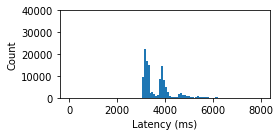

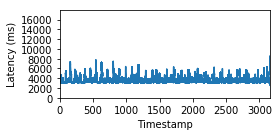

average latency is:
3673.67914287
min latency is:
2537
max latency is:
8596
quantiles:
4603.0
4953.0
5990.059999999998


In [2]:
drawAggregationFigures('../results/spark_agg_2node_th_max.csv','../paper/images/eps/spark_agg_2node_th_max'
                       ,[0,8000],(4,2),100,500, (0,40000), 2000, 0, (0,18000))




###  2 node, 8-4 window, 4000 batch, th_90

Parameters:
- 339K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 25 tuples generated
- parallelism 32
- block interval 800ms




18000


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


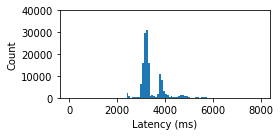

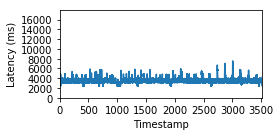

average latency is:
3411.82318728
min latency is:
2354
max latency is:
7548
quantiles:
3933.0
4529.0
5375.459999999992


In [62]:
drawAggregationFigures('../results/spark_agg_2node_th_90.csv','../paper/images/eps/spark_agg_2node_th_90'
                       ,[0,8000],(4,2),100,500, (0,40000), 2000, 7800, (0,18000))



###  4 node, 8-4 window, 4000 batch, th_max

Parameters:
- 642K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 50 tuples generated
- parallelism 64
- block interval 200ms




18000


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


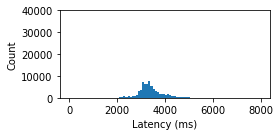

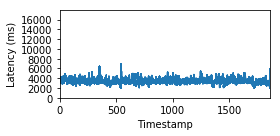

average latency is:
3394.51184562
min latency is:
1987
max latency is:
6934
quantiles:
4076.100000000006
4315.0
4955.210000000006


In [63]:
drawAggregationFigures('../results/spark_agg_4node_th_max.csv','../paper/images/eps/spark_agg_4node_th_max'
                       ,[0,8000],(4,2),100,500, (0,40000), 2000,0, (0,18000))




###  4 node, 8-4 window, 4000 batch, th_90

Parameters:
- 576K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 44 tuples generated
- parallelism 64
- block interval 200ms



18000


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


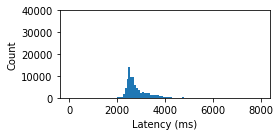

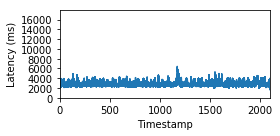

average latency is:
2814.68685837
min latency is:
1630
max latency is:
6424
quantiles:
3466.0
3753.0
4731.4100000000035


In [64]:
drawAggregationFigures('../results/spark_agg_4node_th_90.csv','../paper/images/eps/spark_agg_4node_th_90'
                       ,[0,8000],(4,2),100,500, (0,40000), 2000,6500, (0,18000))



###  8 node, 8-4 window, 4000 batch th_max

Parameters:
- 912K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 75 tuples generated
- parallelism 128
- block interval 200ms





18000


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


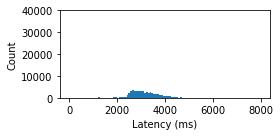

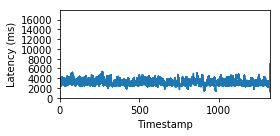

average latency is:
3139.07759643
min latency is:
1223
max latency is:
6946
quantiles:
3896.0
4162.0
4711.0


In [65]:
drawAggregationFigures('../results/spark_agg_8node_th_max.csv','../paper/images/eps/spark_agg_8node_th_max'
                       ,[0,8000],(4,2),100,500, (0,40000), 2000,0, (0,18000))





###  8 node, 8-4 window, 4000 batch th_90

Parameters:
- 810K tuples/second Data generation rate and throughout
- Sleep 1 ms for every 65 tuples generated
- parallelism 128
- block interval 200ms





18000


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


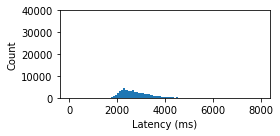

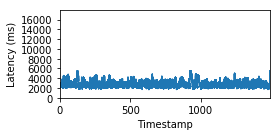

average latency is:
2773.37394923
min latency is:
1702
max latency is:
5497
quantiles:
3612.0
3920.199999999997
4580.639999999999


In [66]:

drawAggregationFigures('../results/spark_agg_8node_th_90.csv','../paper/images/eps/spark_agg_8node_th_90'
                       ,[0,8000],(4,2),100,500, (0,40000), 2000,5500, (0,18000))


